FRAUD DETECTION EDA - FRISS

In the following notebook I perfrom EDA on the fraud detection training dataset with the aim of creating a Fraud Detection API as the next step.

The findings of the EDA will be used on the development of features for ML algorithms like XGBoost and for the curration of a prompts for the LLM usage.
Additionally for the creation of a vector database.

# This notebook was developed in google collab so the file location might differ if you try to run it locally

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Display settings
pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid")


In [3]:
# Update the paths if running locally
claims = pd.read_csv("FRISS_ClaimHistory_training.csv")
frauds = pd.read_csv("fraud_cases.csv")
test = pd.read_csv("FRISS_ClaimHistory_test.csv")

print(f"Training shape: {claims.shape}")
print(f"Fraud shape: {frauds.shape}")
print(f"Test shape: {test.shape}")


Training shape: (80000, 20)
Fraud shape: (618, 2)
Test shape: (20000, 21)


**Let's see how our dataset looks**

In [15]:
claims.tail(5)

,sys_sector,sys_label,sys_process,sys_product,sys_dataspecification_version,sys_claimid,sys_currency_code,claim_amount_claimed_total,claim_causetype,claim_date_occurred,claim_date_reported,claim_location_urban_area,object_make,object_year_construction,ph_firstname,ph_gender,ph_name,policy_fleet_flag,policy_insured_amount,policy_profitability,label
79995,Private NonLife,FRISS,Claims_initial_load,MOTOR,4.5,MTR-660834996-02,EUR,2570.0,Collision,20130430,20130514,1,VOLKSWAGEN,2011.0,Marjaana,F,el-Popal,0,NaN,High,0
79996,Private NonLife,FRISS,Claims_initial_load,MOTOR,4.5,MTR-825024899-02,EUR,4184.0,Collision,20141028,20141108,1,VOLKSWAGEN,2016.0,Laura,L,Mendez,0,52457.0,Low,0
79997,Private NonLife,FRISS,Claims_initial_load,MOTOR,4.5,MTR-591101349-02,EUR,35338.0,Other,20131128,20131220,0,BMW,2013.0,Muna,F,Turner,0,42827.0,High,0
79998,Private NonLife,FRISS,Claims_initial_load,MOTOR,4.5,MTR-790242664-02,EUR,40.0,Collision,20160401,20160401,1,OTHER,2010.0,Eli,M,Meraz,0,55022.0,Low,0
79999,Private NonLife,FRISS,Claims_initial_load,MOTOR,4.5,MTR-815745885-02,EUR,946.0,Weather,20171009,20171226,1,VOLKSWAGEN,1999.0,Humaira,F,el-Jabbour,1,NaN,Neutral,0


In [16]:
frauds.tail(5)

,ClaimID,Date_Occurred
613,996761840,20171229
614,833264435,20180119
615,903354992,20180119
616,843869673,20180128
617,382460479,20180206


**An important step moving forward is adding a column in our training set as a label.**
To do so we will merge the frauds to the claims based on the **sys_claimid**, if you inspect though the structure of the strings are not the same in claims and frauds.

In [10]:
test.head(5)

,sys_sector,sys_label,sys_process,sys_product,sys_dataspecification_version,sys_claimid,sys_currency_code,claim_amount_claimed_total,claim_causetype,claim_date_occurred,claim_date_reported,claim_location_urban_area,object_make,object_year_construction,ph_firstname,ph_gender,ph_name,policy_fleet_flag,policy_insured_amount,policy_profitability,sys_fraud
0,Private NonLife,FRISS,Claims_initial_load,MOTOR,4.5,MTR-666202639-02,EUR,2627.0,Collision,20150521,20160916,0,OTHER,2014.0,Shishan,F,Lor,0,114718.0,Very low,0
1,Private NonLife,FRISS,Claims_initial_load,MOTOR,4.5,MTR-258901077-02,EUR,269.0,Other,20130302,20130304,0,AUDI,1999.0,Dominic,M,Purnell,0,117522.0,Neutral,0
2,Private NonLife,FRISS,Claims_initial_load,MOTOR,4.5,MTR-547929317-02,EUR,157.0,Collision,20121030,20121127,1,RENAULT,2009.0,Katalina,F,Shea,0,72287.0,Low,0
3,Private NonLife,FRISS,Claims_initial_load,MOTOR,4.5,MTR-745856657-02,EUR,299.0,Collision,20150824,20150826,0,BMW,2008.0,Ebonee,F,Ryan,0,112630.0,Low,0
4,Private NonLife,FRISS,Claims_initial_load,MOTOR,4.5,MTR-686506389-02,EUR,211.0,Theft,20141126,20141226,0,OTHER,2000.0,Emonie,F,Hester,0,104030.0,Neutral,0


WE already know that we have 618 instances of Fraud in the training and test set out of the 100,000 cases.
That's quite a small amount which leads to an imbalanced dataset.

Since though we aim to Flag potentially Fraudelant cases, we will strive to tune our algorithms to have high Recall - of course we will need to balance this with precision somewhat else we can return as Fraud every new claim - but recall would be the metric of importance as we dont want to miss Frauds.

In [19]:
claims["label"] = claims["sys_claimid"].str.extract(r'MTR-(\d+)-')[0].isin(frauds["ClaimID"].astype(str)).astype(int)
print("Fraud class distribution:\n", claims["label"].value_counts(normalize=True))

Fraud class distribution:
 label
0    0.992313
1    0.007687
Name: proportion, dtype: float64


In [17]:
print("\nData Types:")
print(claims.dtypes)

print("\nMissing Values:")
print(claims.isnull().sum())


Data Types:
sys_sector                        object
sys_label                         object
sys_process                       object
sys_product                       object
sys_dataspecification_version    float64
sys_claimid                       object
sys_currency_code                 object
claim_amount_claimed_total       float64
claim_causetype                   object
claim_date_occurred                int64
claim_date_reported                int64
claim_location_urban_area          int64
object_make                       object
object_year_construction         float64
ph_firstname                      object
ph_gender                         object
ph_name                           object
policy_fleet_flag                  int64
policy_insured_amount            float64
policy_profitability              object
label                              int64
dtype: object

Missing Values:
sys_sector                           0
sys_label                            0
sys_process      

We can observe that we have 30,819 missing values of insured amount out of the 80,000 cases. That's a quite big amount //

In [21]:
claims.describe()

,sys_dataspecification_version,claim_amount_claimed_total,claim_date_occurred,claim_date_reported,claim_location_urban_area,object_year_construction,policy_fleet_flag,policy_insured_amount,label
count,80000.0,80000.000000,8.000000e+04,8.000000e+04,80000.000000,80000.000000,80000.000000,49181.000000,80000.000000
mean,4.5,3222.524212,2.014941e+07,2.014996e+07,0.530813,2008.664625,0.321487,60011.545394,0.007687
std,0.0,9940.736169,1.652238e+04,1.662538e+04,0.499053,5.116219,0.467050,24628.603336,0.087341
min,4.5,2.000000,2.012070e+07,2.012070e+07,0.000000,1948.000000,0.000000,6531.000000,0.000000
25%,4.5,296.000000,2.013122e+07,2.014011e+07,0.000000,2006.000000,0.000000,44928.000000,0.000000
50%,4.5,883.000000,2.015070e+07,2.015072e+07,1.000000,2010.000000,0.000000,53102.000000,0.000000
75%,4.5,2657.000000,2.016101e+07,2.016110e+07,1.000000,2012.000000,1.000000,64159.000000,0.000000
max,4.5,424720.000000,2.018021e+07,2.024081e+07,1.000000,2020.000000,1.000000,193681.000000,1.000000


In [22]:
test.describe()

,sys_dataspecification_version,claim_amount_claimed_total,claim_date_occurred,claim_date_reported,claim_location_urban_area,object_year_construction,policy_fleet_flag,policy_insured_amount,sys_fraud
count,20000.0,20000.00000,2.000000e+04,2.000000e+04,20000.000000,20000.000000,20000.00000,12297.000000,20000.000000
mean,4.5,3263.67540,2.014941e+07,2.014993e+07,0.526400,2008.652450,0.32225,60181.128405,0.006800
std,0.0,9803.28522,1.652183e+04,1.658398e+04,0.499315,5.108636,0.46735,24766.608345,0.082183
min,4.5,2.00000,2.012070e+07,2.012070e+07,0.000000,1948.000000,0.00000,-7490.000000,0.000000
25%,4.5,297.00000,2.013122e+07,2.014011e+07,0.000000,2006.000000,0.00000,44934.000000,0.000000
50%,4.5,897.50000,2.015070e+07,2.015072e+07,1.000000,2010.000000,0.00000,53077.000000,0.000000
75%,4.5,2708.00000,2.016101e+07,2.016110e+07,1.000000,2012.000000,1.00000,64312.000000,0.000000
max,4.5,424720.00000,2.018021e+07,2.022083e+07,1.000000,2020.000000,1.00000,182989.000000,1.000000


The good news are that we observe similars statistics to our train and test set!

**Before we continue with correlation analysis we have to transform our datasets**
**Decisions:**
1. Drop first_name, name and gender for GDPR and BIAS reasons
2. Modify dates in datetime format
3. Drop policy_insured_amount due its HIGH Null percentage - can't really impute with such a big Null
4. Generate new features: a. report_delay_days and b. car_age_at_claim

In [4]:
claims.drop(columns=["ph_name", "ph_firstname", "ph_gender"], inplace=True)


In [5]:
claims.drop(columns=["policy_insured_amount"], inplace=True)


In [6]:
claims["claim_date_occurred"] = pd.to_datetime(claims["claim_date_occurred"], format="%Y%m%d", errors="coerce")
claims["claim_date_reported"] = pd.to_datetime(claims["claim_date_reported"], format="%Y%m%d", errors="coerce")


In [7]:
claims["report_delay_days"] = (claims["claim_date_reported"] - claims["claim_date_occurred"]).dt.days


In [8]:
claims["car_age_at_claim"] = claims["claim_date_reported"].dt.year - claims["object_year_construction"]


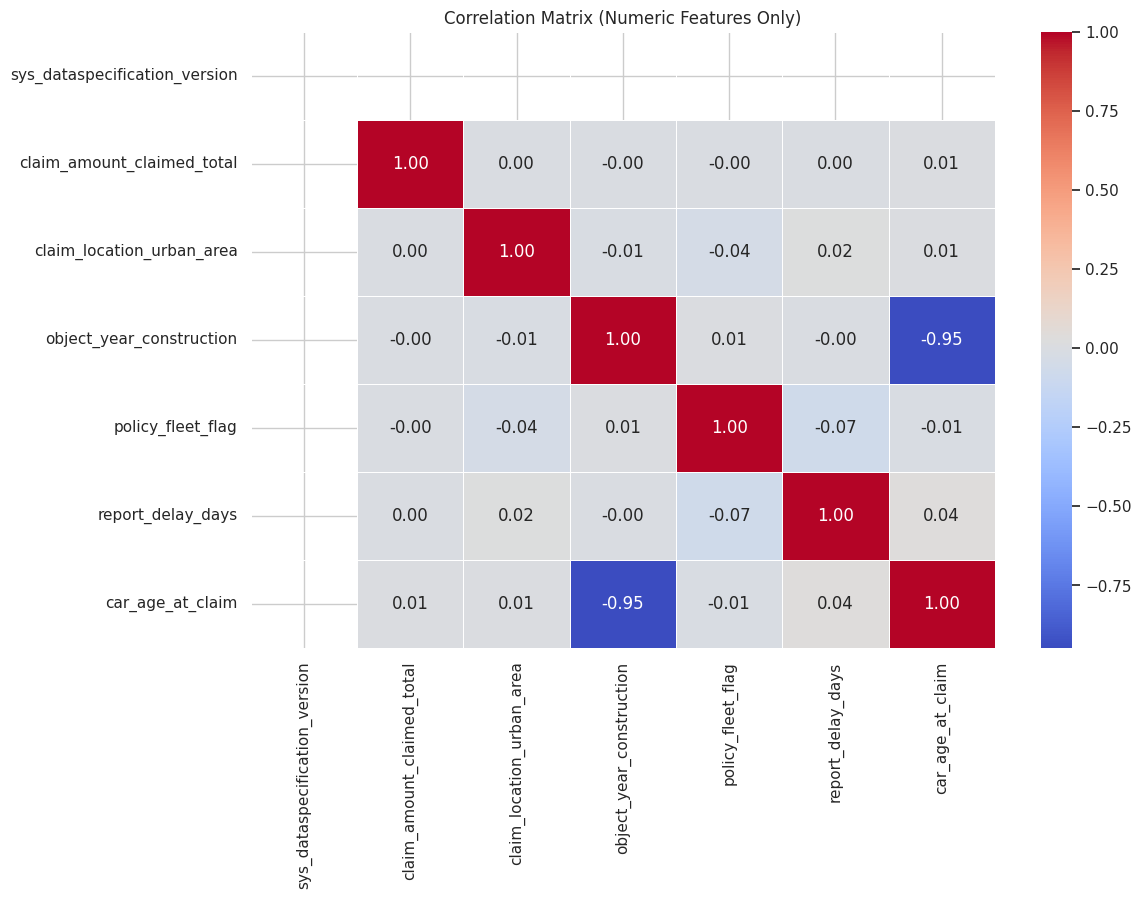

In [9]:
numerical_cols = claims.select_dtypes(include=np.number).columns.tolist()
corr = claims[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Numeric Features Only)")
plt.show()

As expected, the correlations matrix doesnt really showcase us anything due to the extreme big imbalance in the datasets.

We will now do the same preprossesing steps for the test set and save both of them to continue our work.

Let's explore the string variables now
We will look:
1. How many unique values they have and if we should remove them
2. The correlation of the variables we can encode

In [11]:
claims.columns

Index(['sys_sector', 'sys_label', 'sys_process', 'sys_product',
       'sys_dataspecification_version', 'sys_claimid', 'sys_currency_code',
       'claim_amount_claimed_total', 'claim_causetype', 'claim_date_occurred',
       'claim_date_reported', 'claim_location_urban_area', 'object_make',
       'object_year_construction', 'policy_fleet_flag', 'policy_profitability',
       'report_delay_days', 'car_age_at_claim'],
      dtype='object')

In [13]:
categorical_cols = [
    "sys_sector", "sys_label", "sys_process", "sys_product",
    "sys_currency_code", "claim_causetype", "object_make",
    "policy_fleet_flag", "policy_profitability"
]

for col in categorical_cols:
    unique_vals = claims[col].nunique()
    print(f"{col}: {unique_vals} unique values")


sys_sector: 1 unique values
sys_label: 1 unique values
sys_process: 1 unique values
sys_product: 1 unique values
sys_currency_code: 1 unique values
claim_causetype: 5 unique values
object_make: 7 unique values
policy_fleet_flag: 2 unique values
policy_profitability: 5 unique values


In [14]:
# lets drop the ones with 1 unique and lets explore the rest
# Columns to drop
drop_cols = [
    "sys_sector", "sys_label", "sys_process",
    "sys_product", "sys_currency_code"
]

# Drop from both train and test
claims.drop(columns=drop_cols, inplace=True)
test.drop(columns=drop_cols, inplace=True)

In [18]:
claims.head()

,sys_dataspecification_version,sys_claimid,claim_amount_claimed_total,claim_causetype,claim_date_occurred,claim_date_reported,claim_location_urban_area,object_make,object_year_construction,policy_fleet_flag,policy_profitability,report_delay_days,car_age_at_claim
0,4.5,MTR-338957796-02,2433.0,Collision,2012-10-22,2012-11-27,1,VOLKSWAGEN,2008.0,0,Low,36,4.0
1,4.5,MTR-434911509-02,3791.0,Collision,2014-06-12,2014-06-18,1,CITROEN,2003.0,0,Very low,6,11.0
2,4.5,MTR-615568027-02,452.0,Collision,2013-05-06,2013-09-23,1,RENAULT,2001.0,0,Low,140,12.0
3,4.5,MTR-917387010-02,555.0,Collision,2017-11-12,2017-12-06,1,RENAULT,2017.0,0,High,24,0.0
4,4.5,MTR-281513737-02,382.0,Collision,2015-10-21,2015-12-02,1,BMW,2011.0,0,Very high,42,4.0


In [20]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

categorical_cols = [
    "claim_causetype",
    "object_make",
    "policy_fleet_flag",
    "policy_profitability"
]

# Copy & encode categoricals
encoded_df = claims[categorical_cols].copy()
for col in encoded_df.columns:
    encoded_df[col] = LabelEncoder().fit_transform(encoded_df[col])

# Compute mutual info
mi = mutual_info_classif(encoded_df, claims["label"], discrete_features=True)
mi_series = pd.Series(mi, index=categorical_cols).sort_values(ascending=False)

print("📈 Mutual Information with label:\n")
print(mi_series)

📈 Mutual Information with label:

object_make             0.000255
policy_fleet_flag       0.000225
claim_causetype         0.000184
policy_profitability    0.000024
dtype: float64


Time to perform the same preprocessing steps to the test set and then save both of them to be used in the rest of the notebooks

In [29]:
# 1. Drop bias-sensitive columns
test.drop(columns=["ph_name", "ph_firstname", "ph_gender"], inplace=True)

# 2. Drop 'policy_insured_amount' for now (same as train)
test.drop(columns=["policy_insured_amount"], inplace=True)

# 3. Convert date columns
test["claim_date_occurred"] = pd.to_datetime(test["claim_date_occurred"], format="%Y%m%d", errors="coerce")
test["claim_date_reported"] = pd.to_datetime(test["claim_date_reported"], format="%Y%m%d", errors="coerce")

# 4. Create report delay
test["report_delay_days"] = (test["claim_date_reported"] - test["claim_date_occurred"]).dt.days

# 5. Create car age at claim
test["car_age_at_claim"] = test["claim_date_reported"].dt.year - test["object_year_construction"]

# 6. Rename label column to match train
test.rename(columns={"sys_fraud": "label"}, inplace=True)

# 7. Drop rows with missing derived feature values if needed
test.dropna(subset=["report_delay_days", "car_age_at_claim"], inplace=True)

# 8. Drop columns with 1 unique value
test.drop(columns=drop_cols, inplace=True)


In [21]:
test.to_csv("test_set.csv")
claims.to_csv("training_set.csv")